<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/Rajavel_Sethupathi_DonorsChoose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import zipfile
import os
import gdown
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import StandardScaler, Normalizer

In [4]:
zip_url = "https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4"

dataset_path = os.path.join("./dataset", "donors_choose")
zip_file_path = os.path.join(dataset_path, "donors_choose_dataset.zip")

if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)

if not os.path.exists(zip_file_path):
   gdown.download(zip_url, zip_file_path, quiet=False)

with zipfile.ZipFile(zip_file_path ,"r") as zip_ref:
    zip_ref.extractall(dataset_path)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4
From (redirected): https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4&confirm=t&uuid=c2ac7c69-29a3-4b2a-bd2f-140077c86aab
To: /content/dataset/donors_choose/donors_choose_dataset.zip
100%|██████████| 111M/111M [00:04<00:00, 26.2MB/s]


In [5]:
# read the files
dc_resources = pd.read_csv('/content/dataset/donors_choose/resources.csv')
dc_train_data = pd.read_csv('/content/dataset/donors_choose/train_data.csv')


In [ ]:
dc_resources.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [ ]:
dc_train_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0


In [6]:
dc_resources.shape

(1541272, 4)

In [7]:
dc_train_data.shape

(109248, 17)

In [8]:
dc_train_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [9]:
dc_resources.columns

Index(['id', 'description', 'quantity', 'price'], dtype='object')

In [ ]:
dc_train_data.dtypes

Unnamed: 0                                       int64
id                                              object
teacher_id                                      object
teacher_prefix                                  object
school_state                                    object
project_submitted_datetime                      object
project_grade_category                          object
project_subject_categories                      object
project_subject_subcategories                   object
project_title                                   object
project_essay_1                                 object
project_essay_2                                 object
project_essay_3                                 object
project_essay_4                                 object
project_resource_summary                        object
teacher_number_of_previously_posted_projects     int64
project_is_approved                              int64
dtype: object

In [ ]:
dc_resources.dtypes

id              object
description     object
quantity         int64
price          float64
dtype: object

In [10]:
dc_train_data.describe()

,Unnamed: 0,teacher_number_of_previously_posted_projects,project_is_approved
count,109248.000000,109248.000000,109248.000000
mean,91183.786568,11.153165,0.848583
std,52548.095272,27.777154,0.358456
min,0.000000,0.000000,0.000000
25%,45743.500000,0.000000,1.000000
50%,91253.500000,2.000000,1.000000
75%,136712.500000,9.000000,1.000000
max,182079.000000,451.000000,1.000000


**From observing the data, the following categorical features are noted -**

* project_grade_category
* project_subject_categories
* project_subject_subcategories
* teacher_prefix
* school_state


## **Pre-processing project_grade_category**


---



In [12]:
dc_train_data['project_grade_category'].value_counts()

project_grade_category
Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: count, dtype: int64

In [13]:
# Removing all the spaces, replace the '-' with '_' and convert all the letters to small

dc_train_data['project_grade_category'] = dc_train_data['project_grade_category'].str.replace(' ','_').str.replace('-', '_')
dc_train_data['project_grade_category'] = dc_train_data['project_grade_category'].str.lower()
dc_train_data['project_grade_category'].value_counts()

project_grade_category
grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: count, dtype: int64

## **Pre-processing project_subject_categories**

In [14]:
dc_train_data['project_subject_categories'].value_counts()

project_subject_categories
Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning     

In [15]:
# trim spaces, replace '&' with '_', and ',' with '_'
dc_train_data['project_subject_categories'] = dc_train_data['project_subject_categories'].str.replace(' The ','').str.replace(' ','').str.replace('&','_').str.replace(',','_')
dc_train_data['project_subject_categories'] = dc_train_data['project_subject_categories'].str.lower()
dc_train_data['project_subject_categories'].value_counts()

project_subject_categories
literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_

## **Pre-processing project_subject_subcategories**

In [16]:
dc_train_data['project_subject_subcategories'].value_counts()

project_subject_subcategories
Literacy                             9486
Literacy, Mathematics                8325
Literature & Writing, Mathematics    5923
Literacy, Literature & Writing       5571
Mathematics                          5379
                                     ... 
Community Service, Gym & Fitness        1
Parent Involvement, Team Sports         1
Gym & Fitness, Social Sciences          1
Community Service, Music                1
Economics, Foreign Languages            1
Name: count, Length: 401, dtype: int64

In [17]:
# trim spaces,  replace '&' with '_', and ',' with '_'
dc_train_data['project_subject_subcategories'] = dc_train_data['project_subject_subcategories'].str.replace(' The ','').str.replace(' ','').str.replace('&','_').str.replace(',','_')
dc_train_data['project_subject_subcategories'] = dc_train_data['project_subject_subcategories'].str.lower()
dc_train_data['project_subject_subcategories'].value_counts()

project_subject_subcategories
literacy                          9486
literacy_mathematics              8325
literature_writing_mathematics    5923
literacy_literature_writing       5571
mathematics                       5379
                                  ... 
communityservice_gym_fitness         1
parentinvolvement_teamsports         1
gym_fitness_socialsciences           1
communityservice_music               1
economics_foreignlanguages           1
Name: count, Length: 401, dtype: int64

## **Preprocessing teacher_prefix**


In [21]:
dc_train_data['teacher_prefix'].value_counts()

teacher_prefix
Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: count, dtype: int64

In [23]:
# check for missing values and fill them with most frequently occuring element and that happens to be Mrs.
print(" Number of NaN missing values: ",dc_train_data['teacher_prefix'].isnull().values.sum())

dc_train_data['teacher_prefix']=dc_train_data['teacher_prefix'].fillna('Mrs.')

dc_train_data['teacher_prefix'].value_counts()

 Number of NaN missing values:  0


teacher_prefix
Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: count, dtype: int64

In [ ]:
# make all characters lowercase

dc_train_data['teacher_prefix'] = dc_train_data['teacher_prefix'].str.replace('.','')
dc_train_data['teacher_prefix'] = dc_train_data['teacher_prefix'].str.lower()
dc_train_data['teacher_prefix'].value_counts()

teacher_prefix
mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: count, dtype: int64

## **Preprocessing school_state**

In [ ]:
dc_train_data['school_state'].value_counts()

school_state
CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: count, dtype: int64

In [ ]:
# make all characters lowercase
dc_train_data['school_state'] = dc_train_data['school_state'].str.lower()
dc_train_data['school_state'].value_counts()

school_state
ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: count, dtype: int64

## **Preprocessing project_title**

In [11]:
# removing the words from the stop words list - ref - https://gist.github.com/sebleier/554280
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Expand language contractions ref - https://stackoverflow.com/a/47091490/4084039
import re

def remove_lang_contraction(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



In [ ]:
dc_train_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [ ]:
from tqdm import tqdm
# tqdm is for printing the status bar
def preprocess_text(text_data):
    preprocessed_text = []
    for current_sentence in tqdm(text_data):

        # Expanding language contractions
        current_sentence = remove_lang_contraction(current_sentence)
        current_sentence = current_sentence.replace('\\r', ' ')
        current_sentence = current_sentence.replace('\\n', ' ')
        current_sentence = current_sentence.replace('\\"', ' ')
        current_sentence = re.sub('[^A-Za-z0-9]+', ' ', current_sentence)

        # Removing all stopwords
        current_sentence = ' '.join(e for e in current_sentence.split() if e.lower() not in stopwords)
        preprocessed_text.append(current_sentence.lower().strip())
    return preprocessed_text

In [ ]:
preprocessed_titles_train = preprocess_text(dc_train_data['project_title'].values)

dc_train_data['project_title'] = preprocessed_titles_train

100%|██████████| 109248/109248 [00:01<00:00, 62413.70it/s]


In [ ]:
# verification after processing
dc_train_data['project_title'].head(5)

0          educational support english learners home
1                   wanted projector hungry learners
2    soccer equipment awesome middle school students
3                             techie kindergarteners
4                             interactive math tools
Name: project_title, dtype: object

## **Preprocessing project_essay**

In [ ]:
# the fields project_essay_1, project_essay_2, project_essay_3 and project_essay_4 are combined to project_essay
dc_train_data["project_essay"] = dc_train_data["project_essay_1"].map(str) +\
                        dc_train_data["project_essay_2"].map(str) + \
                        dc_train_data["project_essay_3"].map(str) + \
                        dc_train_data["project_essay_4"].map(str)

In [ ]:
dc_train_data['project_essay'].head()

0    My students are English learners that are work...
1    Our students arrive to our school eager to lea...
2    \r\n\"True champions aren't always the ones th...
3    I work at a unique school filled with both ESL...
4    Our second grade classroom next year will be m...
Name: project_essay, dtype: object

In [ ]:
preprocessed_dc_train_data = preprocess_text(dc_train_data['project_essay'].values)
dc_train_data['project_essay'] = preprocessed_dc_train_data

100%|██████████| 109248/109248 [00:47<00:00, 2316.62it/s]


In [ ]:
# verification after processing
dc_train_data['project_essay'].head()

0    students english learners working english seco...
1    students arrive school eager learn polite gene...
2    true champions not always ones win guts mia ha...
3    work unique school filled esl english second l...
4    second grade classroom next year made around 2...
Name: project_essay, dtype: object

## **Preprocessing price**

In [ ]:
dc_resources.shape

(1541272, 4)

In [ ]:
# first step:  summing all the price and quantity that belongs to the same project id, and reset index to make up for missing rows with this operation
dc_res_data = dc_resources.groupby('id').agg({'price': 'sum', 'quantity': 'sum'}).reset_index()
dc_res_data.head()

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [ ]:
# second step - get the cost from price and quantity as a new column
dc_res_data['dc_res_cost'] = dc_res_data['price'] * dc_res_data['quantity']
dc_res_data.head()

,id,price,quantity,dc_res_cost
0,p000001,459.56,7,3216.92
1,p000002,515.89,21,10833.69
2,p000003,298.97,4,1195.88
3,p000004,1113.69,98,109141.62
4,p000005,485.99,8,3887.92


In [ ]:
# keeping just the new cost column
dc_res_data = dc_res_data.drop(['price','quantity'], axis =1)
dc_res_data.head()

,id,dc_res_cost
0,p000001,3216.92
1,p000002,10833.69
2,p000003,1195.88
3,p000004,109141.62
4,p000005,3887.92


## **Mergiing resource cost with train data**

In [ ]:
train_data_original = pd.merge(dc_train_data, dc_res_data, on='id', how='left')
train_data_original['dc_res_cost'].head()
#print(train_data_original.columns)


0     3555.80
1      299.00
2    11370.70
3      931.60
4      271.92
Name: dc_res_cost, dtype: float64

In [ ]:
train_data_original.head()


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,resource_cost
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23,3555.80
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1,299.00
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22,11370.70
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,grades_prek_2,literacy_language_math_science,literacy_mathematics,Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,232.90,4,931.60
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,grades_prek_2,math_science,mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,67.98,4,271.92


In [ ]:
train_data_original['resource_cost'].head()

0     3555.80
1      299.00
2    11370.70
3      931.60
4      271.92
Name: resource_cost, dtype: float64

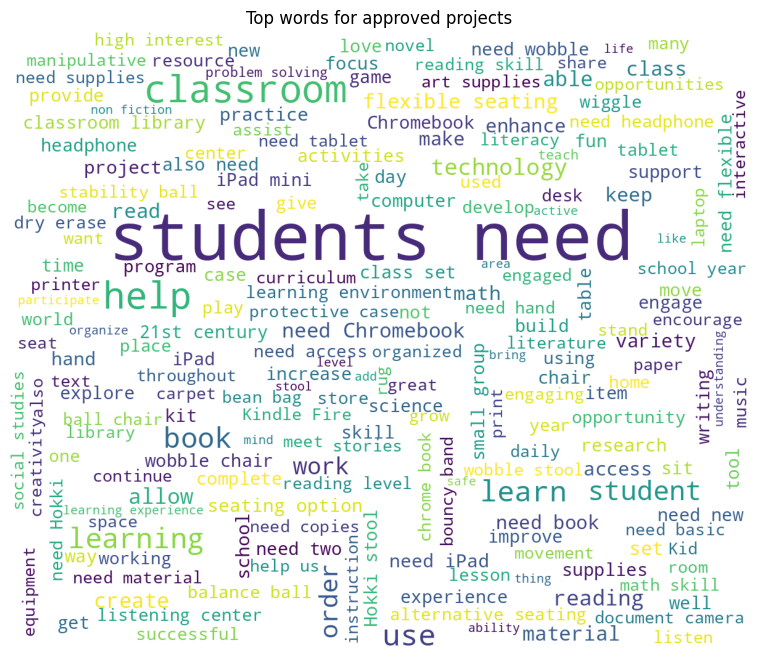

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud_for_project_resource_summary = ' '.join(train_data_original.loc[train_data_original['project_is_approved'] == 1, 'project_resource_summary'].values)

wordcloud = WordCloud(max_font_size=None, stopwords=stopwords, background_color='white',
                      width=1200, height=1000).generate(word_cloud_for_project_resource_summary)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words for approved projects')
plt.axis("off")
plt.show()

In [ ]:
cols_to_drop_from = [
    'id',
    'teacher_id',
    'project_submitted_datetime',
    'project_resource_summary'
]

train_df_pre_processed_original = train_data_original.drop(cols_to_drop_from, axis=1)

# test_project_data_original.drop(cols_to_drop)
print('after dropping ', train_df_pre_processed_original.columns)

after dropping  Index(['Unnamed: 0', 'teacher_prefix', 'school_state',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'project_essay', 'dc_res_cost'],
      dtype='object')


In [ ]:
train_df_pre_processed_original.head()

,Unnamed: 0,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,project_is_approved,project_essay,dc_res_cost
0,160221,mrs,in,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,0,0,students english learners working english seco...,3555.80
1,140945,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,7,1,students arrive school eager learn polite gene...,299.00
2,21895,ms,az,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,1,0,true champions not always ones win guts mia ha...,11370.70
3,45,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,4,1,work unique school filled esl english second l...,931.60
4,172407,mrs,tx,grades_prek_2,math_science,mathematics,interactive math tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,1,1,second grade classroom next year made around 2...,271.92


In [ ]:
y_train_pre_processed_original = train_df_pre_processed_original['project_is_approved'].values
x_train_pre_processed_original = train_df_pre_processed_original.drop(['project_is_approved'], axis=1)

X_donor_choose_train, X_donor_choose_validation, y_donor_choose_train, y_donor_choose_validation = train_test_split(x_train_pre_processed_original, y_train_pre_processed_original, test_size=0.23, stratify=y_train_pre_processed_original)
print('X_donor_choose_train shape ', X_donor_choose_train.shape)

X_donor_choose_train.head(1)

X_donor_choose_train shape  (84120, 14)


,Unnamed: 0,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,project_essay,dc_res_cost
87604,50616,ms,wa,grades_prek_2,literacy_language,literacy,early readers,I work with an incredible group of students wh...,My students are working on early reading skill...,NaN,NaN,0,work incredible group students require really ...,1679.8


In [ ]:
print('x_train_pre_processed_original name of all columns values ', x_train_pre_processed_original.columns)


x_train_pre_processed_original name of all columns values  Index(['Unnamed: 0', 'teacher_prefix', 'school_state',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'resource_cost'],
      dtype='object')


In [ ]:
vectorizer_clean_categories = CountVectorizer(lowercase=False, binary=True)

train_vectorized_ohe_clean_categories = vectorizer_clean_categories.fit_transform(X_donor_choose_train['project_subject_categories'].values)
print(train_vectorized_ohe_clean_categories.shape)

validation_vectorized_ohe_clean_categories = vectorizer_clean_categories.transform(X_donor_choose_validation['project_subject_categories'].values)
print(validation_vectorized_ohe_clean_categories.shape)



(84120, 49)
(25128, 49)


In [ ]:
vectorizer_clean_subcategories = CountVectorizer(lowercase=False, binary=True)

train_vectorized_ohe_clean_subcategories = vectorizer_clean_subcategories.fit_transform(X_donor_choose_train['project_subject_subcategories'].values)
print(train_vectorized_ohe_clean_subcategories.shape)

validation_vectorized_ohe_clean_subcategories = vectorizer_clean_subcategories.transform(X_donor_choose_validation['project_subject_subcategories'].values)
print(validation_vectorized_ohe_clean_subcategories.shape)


(84120, 396)
(25128, 396)


In [ ]:
vectorizer_teacher_prefix = CountVectorizer(lowercase=False, binary=True)

train_vectorized_ohe_teacher_prefix = vectorizer_teacher_prefix.fit_transform(X_donor_choose_train['teacher_prefix'].values)
print(train_vectorized_ohe_teacher_prefix.shape)

validation_vectorized_ohe_teacher_prefix = vectorizer_teacher_prefix.transform(X_donor_choose_validation['teacher_prefix'].values)
print(validation_vectorized_ohe_teacher_prefix.shape)


(84120, 5)
(25128, 5)


In [ ]:
vectorizer_project_grade_category = CountVectorizer(lowercase=False, binary=True)

train_vectorized_ohe_project_grade_category = vectorizer_project_grade_category.fit_transform(X_donor_choose_train['project_grade_category'].values)
print(train_vectorized_ohe_project_grade_category.shape)

validation_vectorized_ohe_project_grade_category = vectorizer_project_grade_category.transform(X_donor_choose_validation['project_grade_category'].values)
print(validation_vectorized_ohe_project_grade_category.shape)


(84120, 4)
(25128, 4)


In [ ]:
vectorizer_school_state = CountVectorizer(lowercase=False, binary=True)

train_vectorized_ohe_school_state = vectorizer_school_state.fit_transform(X_donor_choose_train['school_state'].values)
print(train_vectorized_ohe_school_state.shape)

validation_vectorized_ohe_school_state = vectorizer_school_state.transform(X_donor_choose_validation['school_state'].values)
print(validation_vectorized_ohe_school_state.shape)


(84120, 51)
(25128, 51)
